# NLP X - HEC Embeddings session 4: Advanced Representations


In this practical session, we will focus on word embeddings through word2vec, a simple and more advanced classification models for sentiment analysis (reviews ratings prediction). Once a negative sampling word2vec skipgram is trained, we can visualize learned word vectors in a reduced space and use them in our classification model.

You will be asked to :
1. **Train your own word embeddings with Skipgram** and Tensorflow using **Negative Sampling** method





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Import data

In [ ]:
import os

### COMPLETE HERE ####
## Path of directory on which your data is stored
##dirpath = " "
### END COMPLETE HERE ####

dirpath = "drive/MyDrive" 

# get the list of files in the directory
os.listdir(dirpath)

['Physik Referat Hall-Effekt .pptx',
 'Physik Referat Hall-Effekt .pptx.gslides',
 'Physik Referat Hall-Effekt .gslides',
 'Anwesendheitsliste Panther U19 DB´s 2016.pdf',
 'DSA_Poster_Leistungskatalog_2017_A3_KiJu.pdf',
 'die_welt_kafkas_l.pdf',
 'Analyse.pdf',
 "AB Q1 (F G1) - 'Lernwortschatz zur französischen Textarbeit' (17.03.2017).pdf",
 'Elternbrief_Umfrage.pdf',
 'Trainingsplan Winter 18.ods',
 'Notability',
 'downloadfile-7.bin',
 'Resume_Christophe_Thomassin.pdf',
 'Resume_Christophe_Thomassin_OnePage.pdf',
 'Colab Notebooks']

In [ ]:
### COMPLETE HERE ####
## Name of the data file
data_file = "reviews.csv"
### END COMPLETE HERE ####


### Data collection and preprocessing

In [ ]:
import io
import re
import tqdm
import warnings
import itertools
from ast import literal_eval

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
import sklearn
from sklearn import decomposition
import tensorflow as tf
import sqlite3

nltk.download("punkt")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tqdm.tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [ ]:
filepath = os.path.join(dirpath, data_file) 
reviews = pd.read_csv("reviews.csv")
reviews.head()

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source
0,0,1,Aucun soucis particulier,Je paie ma facture tous les deux mois en fonct...,Il y a 17 heures,4,NaN,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot
1,1,1,Engie facture a ses clients des sommes…,Engie facture a ses clients des sommes exorbit...,Il y a un jour,1,"Bonjour Julien Blanco,\n\nPour des raisons de ...",Date de l'expérience: 26 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot
2,2,1,Facturation sur consommation d'un autre logement,Ils me facturent sur le pdl du logement au des...,ll y a 3 jours,1,"Bonjour BlooDz,\n\nPour des raisons de confide...",Date de l'expérience: 29 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot
3,3,1,un service client ou il est dur de…,un service client ou il est dur de comprendre ...,ll y a 3 jours,1,"Bonjour Ricanto77,\nPour des raisons de confid...",Date de l'expérience: 29 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot
4,4,1,Client d'ENGIE depuis longtemps toujours satis...,Excellente expérience avec ENGIE et une interl...,Il y a 24 minutes,5,NaN,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot


In [ ]:
reviews.describe(include=['O'])

,titre,verbatim,date,reponse,date_experience,fournisseur,source
count,37294,36314,37294,7972,37294,37294,37294
unique,11699,29565,21654,3867,3393,19,2
top,Avis client,Très bien,le 01/12/2022 par Client.,"Bonjour,",Réponse : Ohm Energie,https://www.avis-verifies.com/avis-clients/edf...,avis_verifies
freq,22971,518,153,1689,801,5080,22970


In [ ]:
reviews.shape

(37294, 10)

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37294 entries, 0 to 37293
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       37294 non-null  int64 
 1   page             37294 non-null  int64 
 2   titre            37294 non-null  object
 3   verbatim         36314 non-null  object
 4   date             37294 non-null  object
 5   note             37294 non-null  int64 
 6   reponse          7972 non-null   object
 7   date_experience  37294 non-null  object
 8   fournisseur      37294 non-null  object
 9   source           37294 non-null  object
dtypes: int64(3), object(7)
memory usage: 2.8+ MB


### Preprocessing & Understanding

Let's visualize a review, contained in `content` column, then perform basic cleaning to get a proper text for each review

In [ ]:
def split_reviews_per_sentence(reviews, col ='verbatim' ):
    reviews["review_sentences"] = reviews[col].progress_apply(
        lambda rvw: nltk.sent_tokenize(rvw)
    )
    return reviews

In [ ]:
reviews['verbatim'][0], type(reviews['verbatim'][0])

("Je paie ma facture tous les deux mois en fonction de ma consommation exacte d'électricité. Cette facture tombe généralement en fin de mois, pile avant ma paie et j'ai donc constamment un peu moins d'une semaine de retard sur le paiement, mais mis a part un sms de rappel je n'ai jamais été harcelé par leurs services et ai même pu bénéficier une paire de fois d'un étalement des paiements quand j'en ai eu besoin. Leur service client est d'ailleurs généralement très agréable et compréhensif.",
 str)

In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 22.6 MB/s eta 0:00:00


In [ ]:
corpus = reviews['verbatim']
import unidecode
def preprocess_comment(comment):
  corpus_l = comment.lower() 

  # In most of the case punctuation do not help on understanding a sentence or a doc
  characters_to_remove = ["@", "/", "#", ".", ",", "!", "?", "(", ")", "-", "_","’","'", "\"", ":"]
  transformation_dict = {initial:" " for initial in characters_to_remove}
  no_punctuation_corpus = corpus_l.translate(str.maketrans(transformation_dict))
 
  no_accent_corpus = unidecode.unidecode(no_punctuation_corpus)
  clean_corpus = no_accent_corpus.replace("\n", "").replace("\xa0", "")
  ## remove numbers 
  clean_corpus = ''.join([i for i in clean_corpus if not i.isdigit()])
  
  return clean_corpus

In [ ]:
reviews =split_reviews_per_sentence(reviews.dropna(), col ='verbatim' )
reviews["review_sentences"][1]

  0%|          | 0/7972 [00:00<?, ?it/s]

['Engie facture a ses clients des sommes exorbitants !',
 'Engie mon facturer un technicien pour le gaz , alors que GRDF m’a bien préciser que le gaz était déjà en service dans mon logement !',
 'Résultat des courses une facture de 71 euros juste pour ouvrir le compteur électrique de mon nouveau logement , concernant le gaz personne est intervenu sur ma chaudière j’ai dû le faire tout seul !',
 'Engie savent prendre l’argent à tord mais quand ont leur explique malheureusement plus personne est là !']

In [ ]:
sentences = list(itertools.chain(*reviews["review_sentences"]))
print(f"Number of total sentences : {len(sentences)}")

Number of total sentences : 25321


In [ ]:
sentences[0]

'Engie facture a ses clients des sommes exorbitants !'

In [ ]:
# Preprocessing
sentences = [preprocess_comment(comment) for comment in sentences]

## Analysis


**Question** : plot the distribution of the number of sentences per review. <br>
When handling sequential/textual data, input length may differ from a review to another. In Deep Learning, knowing input length distribution is important to perform zero-padding or truncating processing.

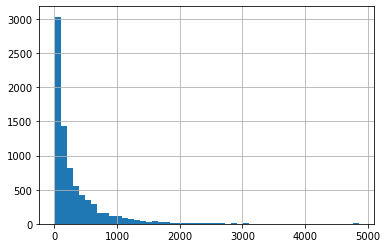

In [ ]:
### FILL THE BLANK ###
reviews["verbatim"].apply(len).hist(bins=50)

In [ ]:
reviews["len_review_sentences"]=reviews["verbatim"].apply(len)

## Tokenization & Text Encoding
This part concerns tokenization and text encoding with TensorFlow modules :

*(i) Build the token vocabulary* <br>
*(ii) Build a text encoder relying each word to an index, and thus each text to a sequence of word indices* (```list```) <br>
*(iii) Build a TensorFlow dataset for word2vec training*



In [ ]:
# Define and fit tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(sentences)

**Question** : use *texts_to_sequences* method of our tokenizer to get sequences from sentences.

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences) ### FILL THE BLANK ###
print(reviews["review_sentences"][1][0], sentences[0], sequences[0], sep="\n\n")

Engie facture a ses clients des sommes exorbitants !

engie facture a ses clients des sommes exorbitants  

[88, 48, 2, 230, 124, 19, 200, 1557]


**Question** : plot the distribution of the number of indices per sequence. <br>
For the same reasons as above, it is important to know length distribution of sentences/sequences.

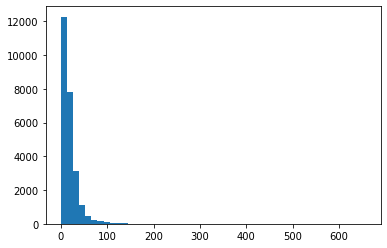

In [ ]:
# Check the distribution of the number of indices per sequence
### FILL THE BLANK ###
plt.hist([len(sequence) for sequence in sequences], bins=50)
plt.show()

# 1. Train our own word embeddings 

## Negative Sampling Skipgram
Preprocessing function which generates skip-gram pairs with negative sampling for a list of sequences (int-encoded sentences) based on window size, number of negative samples and (tokenizer) vocabulary size.

In [ ]:
## Size of the vocabulary
max(tokenizer.index_word.keys())

14711

## Generate training data for word2vec

*(i) Define a sampling table for words in vocabulary, see [make_sampling_table](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/make_sampling_table)* <br>
*(ii) For each sequence (tokenized/indexed sentence), run sliding process (window) and appropriate word sampling to build positive skip-gram word pairs* <br>
*(iii) Iterate over each positive skip-gram pair to produce training examples with positive context word and negative samples, building corresponding labels.* <br>
*(iv) Returns overall combinations of (target word, context word, negative words)*

In [ ]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed=42):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.notebook.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        # Iterate over each positive skip-gram pair to produce training examples 
        # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1, 
                num_sampled=num_ns, 
                unique=True, 
                range_max=vocab_size, 
                seed=seed, 
                name="negative_sampling"
            )

            # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

**Question** : Build training data using ```window_size=2``` and number of negative samples per positive pair ```num_ns=4```. 

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, ### FILL THE BLANK ###
    window_size=2, 
    num_ns=4, 
    vocab_size=max(tokenizer.index_word.keys())+1 ### FILL THE BLANK ### vocab size + 1 for padding
)

print(len(targets), len(contexts), len(labels))

  0%|          | 0/25321 [00:00<?, ?it/s]

211085 211085 211085


In [ ]:
print(targets[0], contexts[0], labels[0], sep="\n\n")

1557

tf.Tensor(
[[ 200]
 [ 376]
 [  31]
 [2321]
 [ 107]], shape=(5, 1), dtype=int64)

tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


In [ ]:
## Determine the tokenization index of target word, context word, and negative samples
index_target =306
index_context =2
list_index_negative = [39, 3734, 143]
### COMPLETE HERE #######
### END COMPLETE HERE #######
## Find the sequence related to targets[0], contexts[0]
chosen_sequence = [i for i in sequences if index_target in i and index_context in i][0]

# Find the index of the chosen_sequences in the sequences list
index_sequence = sequences.index(chosen_sequence)

## Find the sentence related to targets[0], contexts[0]
sentences[index_sequence]

'a quoi sert leur appli de suivi de consommation dans ce cas  et le service client au telephone    il pourrait etre representant en aspirateur ce serait la meme chose '

In [ ]:
## Find the target word, the context word, and the negative samples
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("Target word : ",reverse_word_map.get(index_target))
print("Context word : ", reverse_word_map.get(index_context))
print("Negative samples : ", [reverse_word_map.get(i) for i in list_index_negative])

Target word :  chose
Context word :  a
Negative samples :  ['client', 'perdues', 'offre']


In [ ]:
print(len(targets), len(contexts), len(labels))

211085 211085 211085


## Define TensorFlow dataset
Define valid TensorFlow dataset from targets/contexts/labels iterable objects.
Set two parameters : 
* *BUFFER_SIZE*
* *BATCH_SIZE*

*BATCH_SIZE* can be particularly important for making training efficient. Note that *BATCH_SIZE* must be obviously lower than dataset size.

In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 5, 1), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
for element in dataset.as_numpy_iterator():
  a, label_array = element
  target_array, context_array = a
  print("size of targets : ", target_array.shape)
  print("size of contexts : ",context_array.shape)
  print("size of labels : ",label_array.shape)
  print('###############################\n\n')

size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024,)
size of contexts :  (1024, 5, 1)
size of labels :  (1024, 5)
###############################


size of targets :  (1024

Define Skipgram model

In [ ]:
class Skipgram(tf.keras.Model):
    """Negative Sampling Skigpram implementation.

    ```python
    w2v = Skipgram(vocab_size=4096, embedding_dim=128)
    ````
    """
    def __init__(self, vocab_size, embedding_dim):
        """Skigpram class constructor.

        Parameters
        ----------
        vocab_size: int.
            Size of the vocabulary.

        embedding_dim: int.
            Dimension of trained word2vec Skipgram embeddings.

        """
        super(Skipgram, self).__init__()
        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim,
            input_length=1,
            name="w2v_embedding",
        )
        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim, 
            input_length=4+1, # number of negative samples = 4
            name="context_embedding",
        ) 
        self.dots = tf.keras.layers.Dot(axes=(3,1))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, pair):
        """Model forward method.
        """
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        
        dots = self.dots([ce, we])
        
        return self.flatten(dots)

Define objective and training

In [ ]:
embedding_dim = 128

word2vec = Skipgram(vocab_size=max(tokenizer.index_word.keys())+1, embedding_dim=128)
word2vec.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
word2vec.fit(dataset, epochs=20)

Epoch 1/20
206/206 [==============================] - 31s 131ms/step - loss: 1.5952 - accuracy: 0.3120
Epoch 2/20
206/206 [==============================] - 6s 31ms/step - loss: 1.4548 - accuracy: 0.5082
Epoch 3/20
206/206 [==============================] - 6s 26ms/step - loss: 1.2701 - accuracy: 0.5654
Epoch 4/20
206/206 [==============================] - 2s 11ms/step - loss: 1.1145 - accuracy: 0.6266
Epoch 5/20
206/206 [==============================] - 3s 15ms/step - loss: 0.9848 - accuracy: 0.6786
Epoch 6/20
206/206 [==============================] - 3s 12ms/step - loss: 0.8764 - accuracy: 0.7223
Epoch 7/20
206/206 [==============================] - 2s 9ms/step - loss: 0.7848 - accuracy: 0.7572
Epoch 8/20
206/206 [==============================] - 2s 8ms/step - loss: 0.7068 - accuracy: 0.7859
Epoch 9/20
206/206 [==============================] - 2s 8ms/step - loss: 0.6401 - accuracy: 0.8090
Epoch 10/20
206/206 [==============================] - 2s 10ms/step - loss: 0.5826 - accurac

## Word Embeddings & Visualization

word2vec.summary()

In [ ]:
pretrained_weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
pretrained_weights.shape

(14712, 128)

Let's now visualize the embedding space, in 2 or 3 dimension. We could use a dimensionality reduction method such as PCA, T-SNE or UMAP.

**Question** : after defining PCA object, use *fit_transform* method to get 3D-reduced vectors of word embeddings for visualization and print explained variance ratio.

In [ ]:
def do_pca(pretrained_weights):
    pca = decomposition.PCA(n_components=3)
    reduced_weights = pca.fit_transform(pretrained_weights) ### FILL THE BLANK ###
    return pca, reduced_weights

pca, reduced_weights = do_pca(pretrained_weights)
print(reduced_weights.shape)
print(pca.explained_variance_ratio_) ### FILL THE BLANK ### # explained variance ratio

(14712, 3)
[0.05437315 0.04829147 0.03806205]


In [ ]:
df_pca = pd.DataFrame(data=reduced_weights, columns=["pca_1", "pca_2", "pca_3"])
df_pca["word"] = ["<pad>"] + list(tokenizer.word_index.keys())

In [ ]:
fig = px.scatter_3d(
    df_pca, 
    x="pca_1", 
    y="pca_2", 
    z="pca_3",
    hover_name="word",
    template="plotly_white"
)
fig.update_layout(height=700, width=700)
fig.show()

## Similarities 

In [ ]:
pretrained_weights.shape

(14712, 128)

In [ ]:
tokenizer.index_word.items()

dict_items([(1, 'de'), (2, 'a'), (3, 'et'), (4, 'je'), (5, 'le'), (6, 'que'), (7, 'la'), (8, 'pas'), (9, 'un'), (10, 'en'), (11, 'pour'), (12, 'j'), (13, 'd'), (14, 'est'), (15, 'l'), (16, 'une'), (17, 'ai'), (18, 'les'), (19, 'des'), (20, 'ne'), (21, 'me'), (22, 'n'), (23, 'vous'), (24, 'mon'), (25, 'du'), (26, 'au'), (27, 'qui'), (28, 'on'), (29, 'service'), (30, 'il'), (31, 'plus'), (32, 'sur'), (33, 'ce'), (34, 'm'), (35, 'par'), (36, 'tres'), (37, 'qu'), (38, 'avec'), (39, 'client'), (40, 'c'), (41, 'ils'), (42, 'mais'), (43, 'mois'), (44, 'energie'), (45, 'contrat'), (46, 'nous'), (47, 'ma'), (48, 'facture'), (49, 'bien'), (50, 'dans'), (51, 'fait'), (52, 'chez'), (53, 'suis'), (54, 'ete'), (55, 'demande'), (56, 'electricite'), (57, 'tout'), (58, 'total'), (59, 'eur'), (60, 'apres'), (61, 'sans'), (62, 'meme'), (63, 'faire'), (64, 'fournisseur'), (65, 'leur'), (66, 'avoir'), (67, 'rien'), (68, 'donc'), (69, 'depuis'), (70, 'toujours'), (71, 'alors'), (72, 'sont'), (73, 'telephone

In [ ]:
words =[]
vectors =[]
for idx, word in tokenizer.index_word.items():
  vec = pretrained_weights[idx] # first idx is 1 : skip 0, it's padding.
  words.append(word)
  vectors.append(vec)

In [ ]:
len(tokenizer.index_word)

14711

In [ ]:
pretrained_weights.shape

(14712, 128)

In [ ]:
word = 'soleil' 
index_word = words.index(word)
print(index_word)
vec_word = vectors[index_word]
print(vec_word.shape)
dis_to_word={}
for idx in range(len(vectors)):
  dis_to_word[idx]= np.linalg.norm(vec_word-vectors[idx])
sorted_dis_to_word = {k: v for k, v in sorted(dis_to_word.items(), key=lambda item: item[1])}
list(sorted_dis_to_word.items())[:10]

3901
(128,)


[(3901, 0.0),
 (8827, 2.1589103),
 (8931, 2.1771743),
 (10696, 2.183774),
 (12248, 2.1883588),
 (8854, 2.1990101),
 (5830, 2.2054975),
 (6649, 2.2056158),
 (9885, 2.2077198),
 (4815, 2.209174)]

In [ ]:
for idx in list(sorted_dis_to_word.keys())[:10]:
  print(words[idx])

soleil
fuyercela
ameliorent
comparaisons
recapitulant
deplaisants
generateur
inferieurs
medjadji
expeditif


## Limitations

### Zoom on limitation : Ignoring the intrinsic structure of words

In [ ]:
word = 'borne' 
index_word = words.index(word)
print(index_word)
vec_word_1 = vectors[index_word]

word = 'bornes' 
index_word = words.index(word)
print(index_word)
vec_word_2 = vectors[index_word]


print(np.linalg.norm(vec_word_1-vec_word_2))


1436
11165
2.9136043
